In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kyselykirjasto as kk
import kuvaajakirjasto as kuv
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# TJTS490 Harjoitustyö
### Susanna Lähde & Aatu Laitinen

Data koostettu:

https://www.avoindata.fi/data/fi/dataset/ajoneuvojen-avoin-data/resource/00041d67-966e-48cf-a720-255faf09d55c?
https://www.aut.fi/tilastot/ensirekisteroinnit/henkiloautojen_vuosittaiset_merkki-_ja_mallitilastot

Data koostettiin useammasta lähteestä, koska pääasiallisen datalähteen data oli puutteellista vuodesta 2017 lähtien. 

Ajatellaan, että olemme autojen jälleenmyyjä ja vaihtoautokauppa. Toimimme Suomen suurimmissa kaupunkikeskuksissa.

Meidän liiketoiminnan jatkuuvuden kannalta tärkeimmät tutkimuskysymykset ovat:
1. Markkinatrendit

    Minkä merkkisiä vaihtoautoja kannattaa hankkia?

    Mitä automerkkejä kannattaisi jälleenmyydä?

    Kannattaako myymälöihin hankkia myös sähköautoja?
   
2. Alueelliset erot

    Onko merkkien kysynnässä alueellisia eroja?


# Datan puutteet

<Axes: title={'center': 'Ensirekisteröintien määrät vuosittain'}>

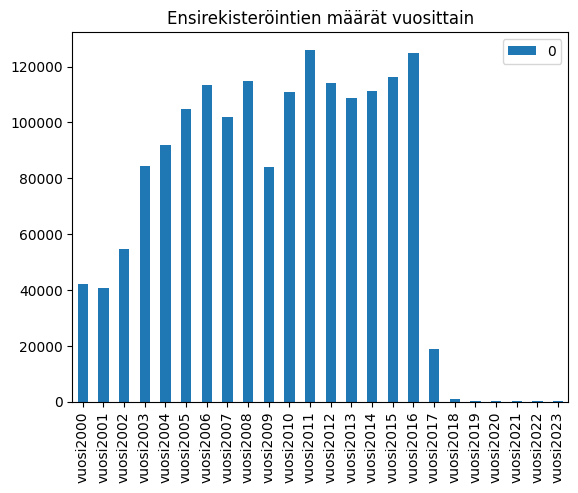

In [3]:
df = kk.ensirekisteroinnit_vuosittain_henkiloauto_luokassa(2000, 2023)
df.drop(columns="yhteensa").transpose().astype("float").plot(kind="bar", title="Ensirekisteröintien määrät vuosittain")

Kuten ylläolevasta taulukosta näkyy, niin data on puutteellista vuodesta 2017 alkaen. Tämän takia tuoreempia myyntitilastoja koostettiin toisesta lähteestä.

In [3]:
df = kk.datan_puutteellisuus_kolumnittain_henkiloauto_luokassa()
df

Cursor created successfully


,merkki,vari,korityyppi,ohjaamotyyppi,istumapaikkojenlkm,omamassa,kayttovoima,iskutilavuus,suurinnettoteho,sylintereidenlkm,ahdin,vaihteisto,vaihteidenlkm,kunta,mittarilukema,yhteensa
0,39,8862,243339,1562005,812,75,28,1164,94216,131159,694816,893553,1001176,27,75570,1898012
1,99.9979,99.5331,87.1793,17.7031,99.9572,99.9960,99.9985,99.9387,95.0361,93.0897,63.3924,52.9216,47.2513,99.9986,96.0185,0


Ylemmällä rivillä näkyy tyhjien arvojen määrä kolumnissa. Alemmalla rivillä näkyy prosenttiosuus ei-tyhjistä riveistä kolumnissa. 

Lähes jokaisessa kolumnissa on yli 90% täysiä arvoja (täysiä??). Kolumnissa ohjaamotyyppi on sen sijaan jopa 83% on tyhjiä (null) arvoja.

# Markkinatrendit
Tutkitaan miten eri merkkien määrä on kehittynyt vuosien varrella ja miten hybridiautojen määrä on kehittynyt.

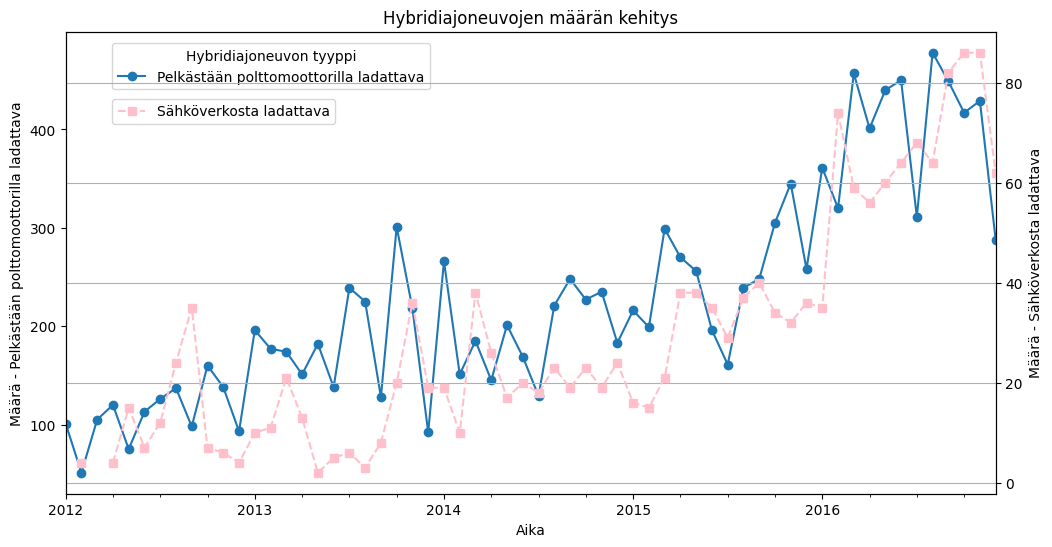

In [28]:
df = kk.hybridiautot_luokittain('M1', 2012, 2016)
df['date'] = pd.to_datetime(df['vuosi'].astype(str) + '-' + df['kuukausi'].astype(str), format='%Y-%m')
condition = df['hybridityyppi'] == 'Ei määritelty'
df = df[~condition]
df_pivot = df.pivot(index='date', columns='hybridityyppi', values='maara')
fig, ax1 = plt.subplots(figsize=(12, 6))

df_pivot.plot(ax=ax1, y='Pelkästään polttomoottorilla ladattava', marker='o', label='Pelkästään polttomoottorilla ladattava')
ax1.set_title('Hybridiajoneuvojen määrän kehitys')
ax1.set_xlabel('Aika')
ax1.set_ylabel('Määrä - Pelkästään polttomoottorilla ladattava')
ax1.legend(title='Hybridiajoneuvon tyyppi',loc=(0.05, 0.875))

ax2 = ax1.twinx()
ax2.set_ylabel('Määrä - Sähköverkosta ladattava') 

#ax2.set_ylim(0, 200) 
df_pivot.plot(ax=ax2, y='Sähköverkosta ladattava', marker='s', linestyle='--', label='Sähköverkosta ladattava', color="pink")
# Creating a legend for the second axis
ax2.legend(loc=(0.05, 0.8))
plt.grid(True)
plt.show()

Molempien hybridityyppien määrä on kasvanut vuosien varrella ja trendi on selkeästi positiivinen. Kuitenkaan määrät eivät ole vielä erityisen suuria.

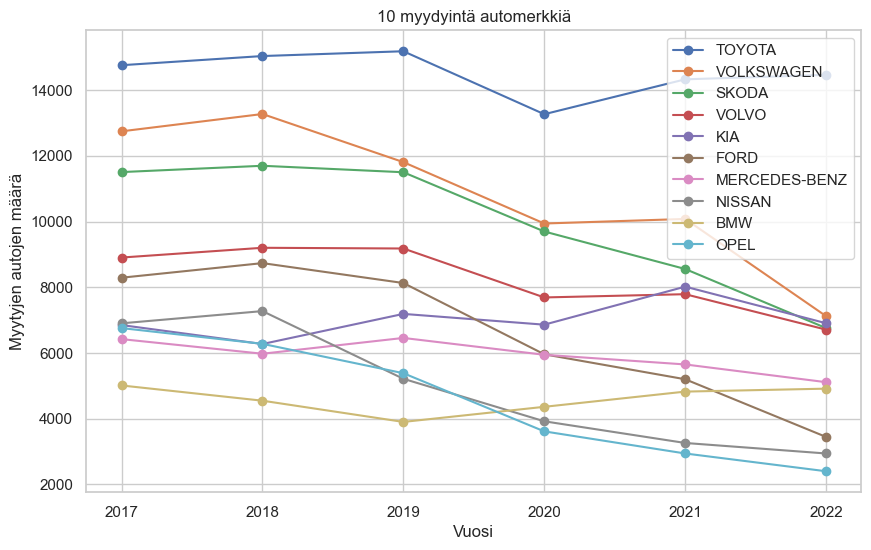

In [40]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
plt.figure(figsize=(10, 6))
for index, row in df_sorted.iterrows():
    plt.plot(df.columns[1:-1], row[1:-1], marker='o', label=row['merkki'])
plt.title('10 myydyintä automerkkiä')
plt.xlabel('Vuosi')
plt.ylabel('Myytyjen autojen määrä')
plt.legend()
plt.grid(True)
plt.show()

Visualisoidaan myös suhteellista muutosta, jolloin on helpompi nähdä yksittäisten merkkien trendit

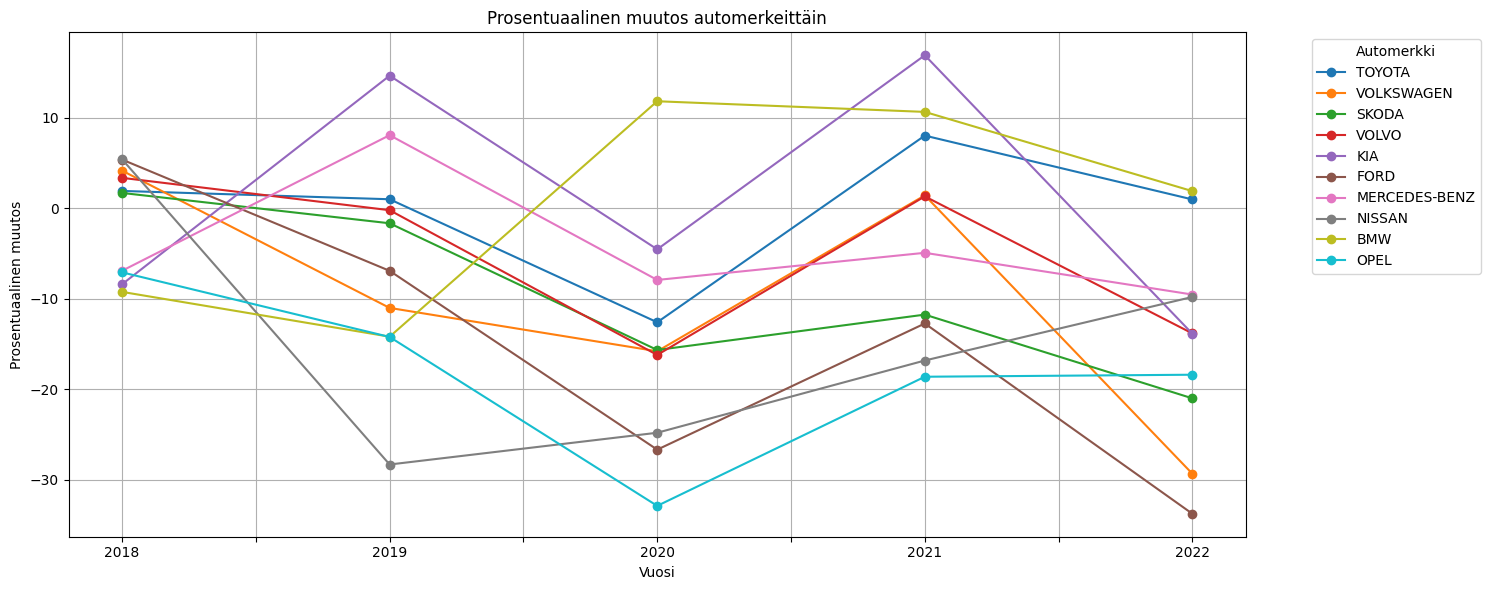

In [41]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
merkit = df_sorted["merkki"].values
df_pc_changes = df_sorted.drop(columns=["merkki", "Total"]).transpose().pct_change() * 100
df_pc_changes = df_pc_changes.transpose()
df_pc_changes["merkki"]= merkit
df_pc_changes.set_index('merkki', inplace=True)
df_transposed = df_pc_changes.transpose()

plt.figure(figsize=(15, 6))
df_transposed.plot(marker='o', linestyle='-', ax=plt.gca())
plt.title('Prosentuaalinen muutos automerkeittäin')
plt.xlabel('Vuosi')
plt.ylabel('Prosentuaalinen muutos')
plt.legend(title='Automerkki', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Suomalaisten suosituimpana automerkkinä on jo monen vuoden ajan pysynyt Toyota. Toisena ja kolmantena tulleiden merkkien Volkswagenin ja Skodan ensirekisteröintien määrät laskivat vuosien varrella monella tuhannella ja ovat nyt Kian ja Volvon kanssa samassa n. 7000 vuosittaisen ensirekisteröinni kanssa. Parin viimeisen vuoden aikana ainoastaan Toyota ja BMW ovat onnistuneet kasvattamaan ensirekisteröintiesä määrää edes vähän. Näiden brändien laskevat markkinaosuudet valuvat todennäköisesti muille brändeille ja erityisesti esimerkiksi uudemmille brändeille, kuten Teslalle, joka keskittyy pelkästään sähköautojen tuotantoon.


Tutkitaan seuraavaksi muutaman tunnetun sähköautomerkin ensirekisteröintien määrän muutosta.

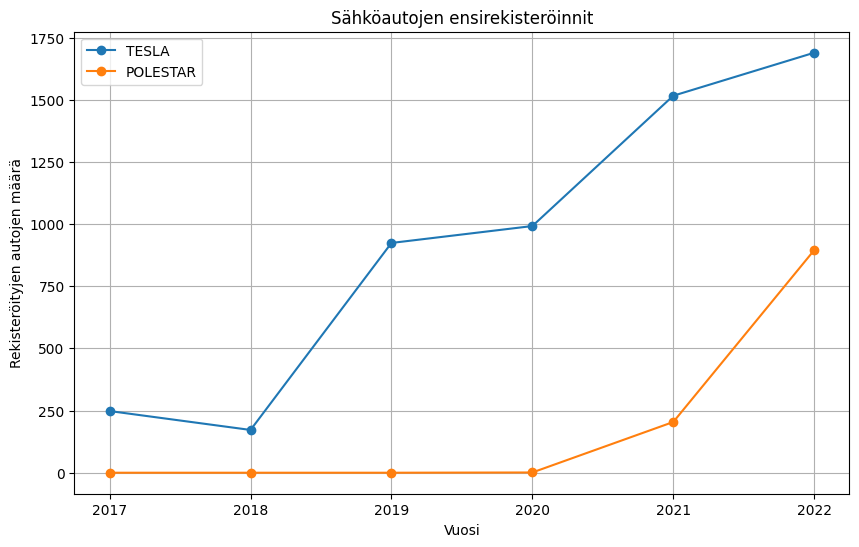

In [4]:
df = kk.ensirekisteroinnit_vuosittain(2017, 2022, 'merkki')
df['Total'] = df[df.columns[1:]].sum(axis=1)
sähköautomerkit = ["TESLA", "POLESTAR"]
df = df[df['merkki'].isin(sähköautomerkit)]
df_sorted = df.sort_values(by='Total', ascending=False).head(10)
plt.figure(figsize=(10, 6))
for index, row in df_sorted.iterrows():
    plt.plot(df.columns[1:-1], row[1:-1], marker='o', label=row['merkki'])
plt.title('Sähköautojen ensirekisteröinnit')
plt.xlabel('Vuosi')
plt.ylabel('Rekisteröityjen autojen määrä')
plt.legend()
plt.grid(True)
plt.show()

Sähköautobrändien myynnin kasvu näyttää odotetunlaiselta.

# Alueelliset erot

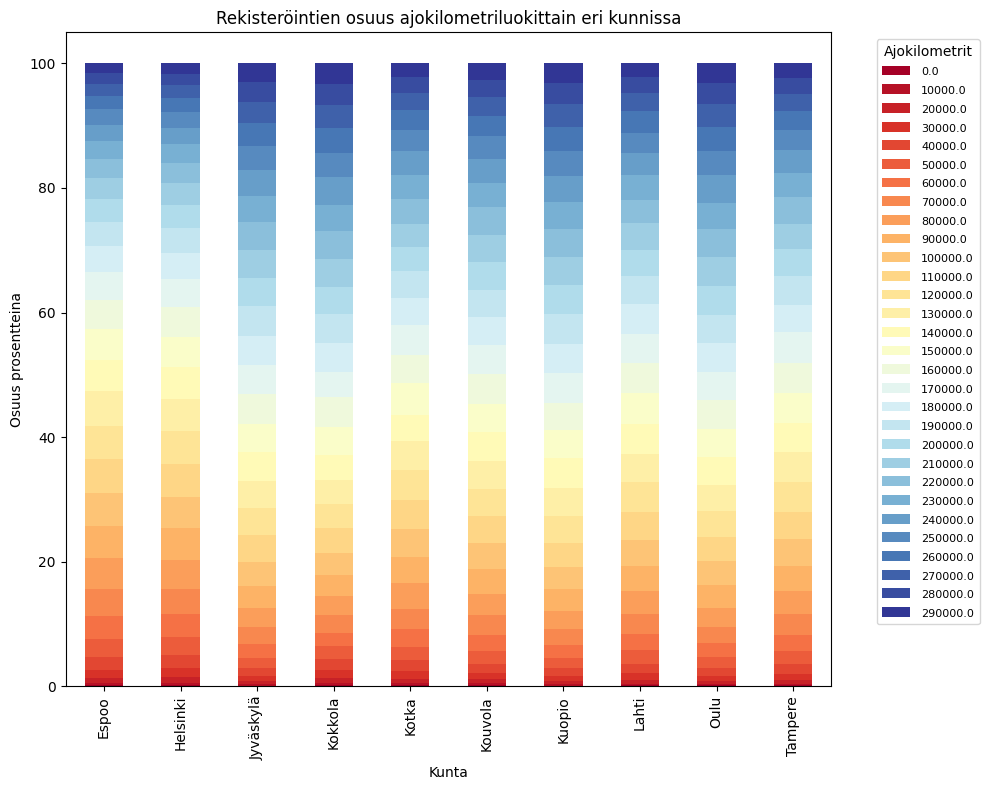

In [3]:
kunnat = ["Helsinki", "Espoo","Tampere","Oulu","Kokkola","Kotka","Jyväskylä","Lahti","Kuopio","Kouvola"]
kuv.rekisterointien_osuus_ajokilometriluokittain_eri_kunnissa(kunnat, 2000, 2016, 10000, 300000)

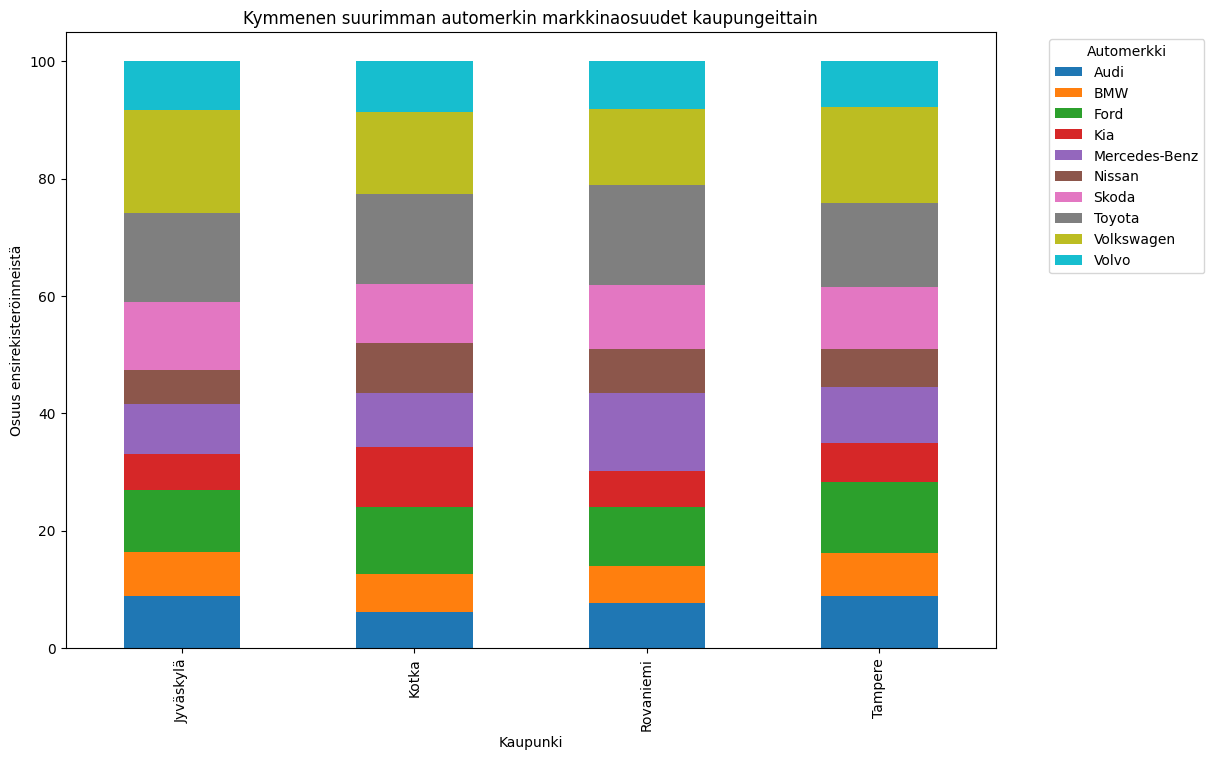

In [6]:
df = kk.ensirekisteroinnit_kunnittain_ajoneuvoluokassa("01.01.2010", "01.01.2016", "M1",["Rovaniemi", "Jyväskylä","Tampere","Kotka"], False)
merkkien_määrät = df.groupby('Merkki')['Määrä'].sum()

isoimmat_merkit = merkkien_määrät.sort_values(ascending=False).head(10).index
df_top10 = df[df['Merkki'].isin(isoimmat_merkit)]
df_pivot = df_top10.pivot_table(index='kunta', columns='Merkki', values='Määrä', aggfunc='sum')
df_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

ax = df_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_xlabel('Kaupunki')
ax.set_ylabel('Osuus ensirekisteröinneistä')
ax.set_title('Kymmenen suurimman automerkin markkinaosuudet kaupungeittain')
ax.legend(title='Automerkki', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

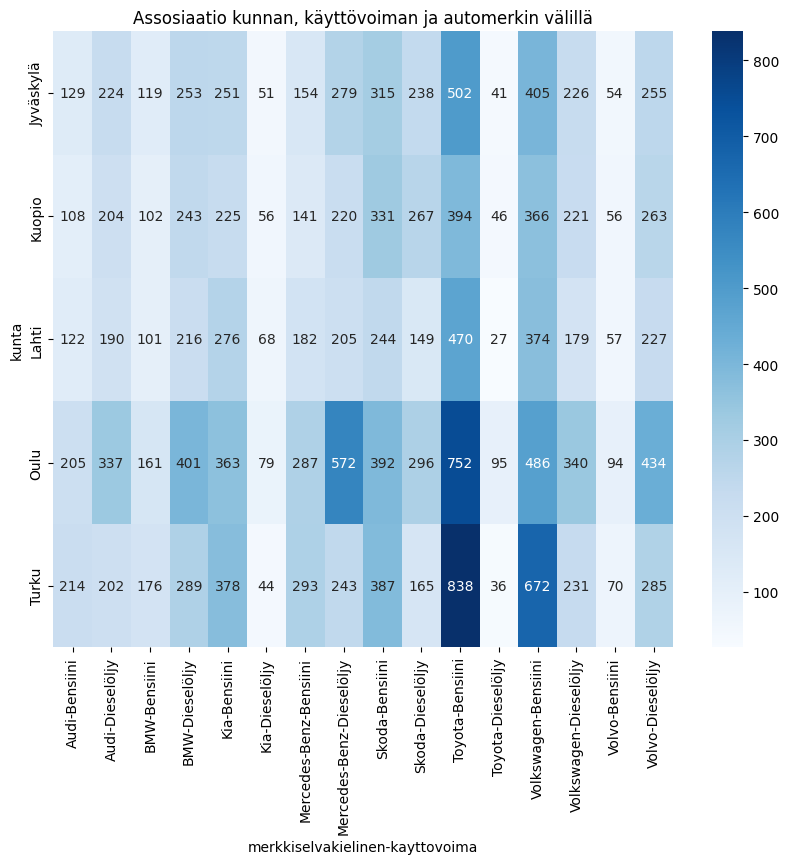

In [9]:
df = kk.rekisteroityjen_autojen_tiedot_aikavalilla(2015, 2016)
df.head()

plt.figure(figsize=(10, 8))

selected_kunta_values = ["Oulu", "Turku", "Jyväskylä", "Kuopio", "Lahti"] 
df_filtered = df[df["kunta"].isin(selected_kunta_values)]

selected_merkki_values = ["BMW", "Volvo", "Audi", "Skoda", "Toyota", "Volkswagen","Mercedes-Benz", "Kia"] 
df_filtered = df_filtered[df_filtered["merkkiselvakielinen"].isin(selected_merkki_values)]

selected_kayttovoima_values = ['Bensiini', 'Dieselöljy']
df_filtered = df_filtered[df_filtered["kayttovoima"].isin(selected_kayttovoima_values)]

assosiaatiot = pd.crosstab(index=df_filtered['kunta'], columns=[df_filtered['merkkiselvakielinen'],df_filtered["kayttovoima"]])
sns.heatmap(assosiaatiot, cmap='Blues', annot=True, fmt='d')
plt.title('Assosiaatio kunnan, käyttövoiman ja automerkin välillä')
plt.show()

Kuvaajasta huomataan, että Kia- tai Toyota-merkkisiä autoja löytyy vain muutamia dieselöljyllä. Volvolla taas isompi osa on diesel-käyttövoimaa ja bensiiniä käyttäviä autoja löytyy huomattavasti vähemmän. Dieselöljy on yleisempi käyttövoima myös BMW:llä, Mercedes-Benzillä ja Audilla.

Oulussa näyttää muista kaupungeista poiketen olevan paljon dieselkäyttövoiman BMW ja Mercedes-Benz merkkisiä autoja. Bensiiniä käyttävä Toyota on vertailussa olleista automerkeistä suosituin jokaisessa kunnassa.

# Yhteenveto

In [ ]:
Käsitellään vielä tärkeimpiä tutkimuskysymyksiä, sitä miten niihin vastattiin ja miten data koostettiin.

Minkä merkkisiä vaihtoautoja kannattaa hankkia?

    Mitä automerkkejä kannattaisi jälleenmyydä?

    Kannattaako myymälöihin hankkia myös sähköautoja?

Näihin tutkimuskysymyksiin vastattiin ylläolevassa markkinatrendit-osiossa. Osiosta löytyy visualisoinnit ja tulosten tulkinta.
Dataa haettiin kahdella eri kyselyllä, jotka löytyvät kyselykirjaston funktioista ensirekisteroinnit_vuosittain ja hybridiautot_luokittain.
   
2. Alueelliset erot

    Onko merkkien kysynnässä alueellisia eroja?